In [1]:
!nvidia-smi
!pip install gdown

Sun May 28 10:01:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   52C    P8    19W / 140W |      0MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!gdown --id "1rdsZgm6Xgi53N5di-Tt-KXVg5YN5WWpD&confirm=t"
!gdown --id "1c_MCkUOxENkjiobj77zyGsRlOXqGuZQR&confirm=t"
!gdown --id "1NPBVQknTHRtZerQpltSQ4p1ESPZZ40sX&confirm=t"

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rdsZgm6Xgi53N5di-Tt-KXVg5YN5WWpD&confirm=t
To: /notebooks/tn_train_100.pt
100%|██████████████████████████████████████| 27.7M/27.7M [00:00<00:00, 40.1MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1c_MCkUOxENkjiobj77zyGsRlOXqGuZQR&confirm=t
To: /notebooks/tn_valid_100.pt
100%|███████████████████████████████████████| 27.6M/27.6M [00:00<00:00, 113MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import List, Tuple


class Eops():
  # Following https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b
  def zero_grad(self):
    for parameter in self.parameters():
      parameter.grad = None

  def _init_weights(self, module: nn.Module):
    classname = module.__class__.__name__
    if classname.find("Linear") != -1:
      nn.init.xavier_uniform_(module.weight)
      if module.bias is not None:
        nn.init.zeros_(module.bias)
    elif classname.find("Conv") != -1:
      nn.init.xavier_uniform_(module.weight)

  def spectral_norm(self, module: nn.Module):
    classname = module.__class__.__name__
    if classname.find("Linear") != -1 or classname.find("Conv") != -1:
      module = torch.nn.utils.parametrizations.spectral_norm(module=module)

  def num_params(self):
    return f"{self.__class__.__name__}: {sum(p.numel() for p in self.parameters())/1e6} M parameters"


class TripletLoss(nn.Module):
  def __init__(self, margin: float = 1.5):
    super(TripletLoss, self).__init__()
    self.register_buffer("margin", torch.tensor(margin))

  def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor = None) -> Tuple[torch.Tensor]:
    """
    Goal: Anchor / Positive -> minimize distance, Anchor / Negative -> maximize distance 
    Implementation available in PyTorch (does not include squaring the distances): nn.TripletMarginLoss(1.5)(anchor, positive, negative).
    """
    loss_dict = { "loss": None }
    euclidean_distance_positive = torch.mean(F.pairwise_distance(anchor, positive, keepdim=True), dim=1)
    loss_dict["ap_distance"] = euclidean_distance_positive
    if negative is not None:
      euclidean_distance_negative = torch.mean(F.pairwise_distance(anchor, negative, keepdim=True), dim=1)
      loss = torch.mean(torch.relu(torch.pow(euclidean_distance_positive, 2) - torch.pow(euclidean_distance_negative, 2) + self.margin))
      loss_dict["loss"] = loss
      loss_dict["an_distance"] = euclidean_distance_negative
      # difference should be > 0 (Anchor-Negative distance should be greater than Anchor-Positive distance)
      loss_dict["an_ap_diff"] = loss_dict["an_distance"] - loss_dict["ap_distance"]

    return loss_dict

In [4]:
import torch 
import sys

import torch.nn as nn
import torch.nn.functional as F


#================ Variables ================#
torch.manual_seed(20801)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128 


class TypeNet(nn.Module, Eops):
  """
  Implementation of the TypeNet with a Triplet Loss (https://arxiv.org/pdf/2101.05570.pdf)
  """
  def __init__(self, window_size: int, interlayer_dropout: float, recurrent_dropout: float):
    super(TypeNet, self).__init__()
    # input size -> [batch_size, 48 (3 time series with the length of window_size), 3 features (keycode, HL, IKI)]
    self.bn1 = nn.BatchNorm1d(window_size)
    self.register_buffer("recurrent_dropout", torch.tensor(recurrent_dropout))
    self.register_buffer("window_size", torch.tensor(window_size))
    self.lstm1 = nn.LSTM(input_size=3, hidden_size=128, num_layers=1, batch_first=True)
    self.interlayer_dropout = nn.Dropout(p=interlayer_dropout)
    self.bn2 = nn.BatchNorm1d(128)
    self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
    print(self.num_params())

  def lstm_forward(self, layer, x):
    _, time_steps, _ = x.size()
    hx = torch.randn(1, 128, device=device)
    cx = torch.randn(1, 128, device=device)
    output = []
    for i in range(time_steps):
      out, (hx, cx) = layer(x[:, i], (hx, cx))
      hx, cx = F.dropout(hx, p=self.recurrent_dropout), F.dropout(cx, p=self.recurrent_dropout)  # recurrent dropout
      output.append(out)
    
    output = torch.stack(output, dim=0)
    return output, (hx, cx)

  def single_forward(self, x):
    x = self.bn1(x)
    x, _ = self.lstm_forward(self.lstm1, x)
    x = self.interlayer_dropout(x)
    x = self.bn2(x)
    x, _ = self.lstm_forward(self.lstm2, x)
    return x

  def forward(self, anchor, positive, negative = None, calculate_loss: bool = True):
    """
    Triplet loss will be used -> the model will return 3 outputs
    A triplet is composed by three different samples from two different classes: 
    Anchor (A) and Positive (P) are different keystroke sequences from the same subject, 
    and Negative (N) is a keystroke sequence from a different subject
    """
    anchor = self.single_forward(anchor)
    positive = self.single_forward(positive)

    if negative is not None:
      negative = self.single_forward(negative)

    if calculate_loss:
      criterion = TripletLoss(margin=1.5)
      losses = criterion(anchor=anchor, positive=positive, negative=negative)

    return anchor, positive, negative, losses


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

#================ Variables ================#

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 128
num_epochs = 100    # -> number of time the model will see whole dataset
epoch_log = 1

window_size = 16
learning_rate = 1e-4  # -> learning rate
adam_beta1 = 0.9 # -> beta1 for AdamW optimizer
adam_beta2 = 0.999 # -> beta2 (momentum) value for AdamW optimizer

#================ Methods ================#

@torch.no_grad()
def evaluate_model(model, dataloader):
    model.eval()
    loss, ap_distance, an_distance, an_ap_diff = 0, 0, 0, 0

    for data in dataloader:
        data = data.to(device)
        anchor, positive, negative = torch.split(data, window_size, dim=1)
        _, _, _, loss_dict = model(anchor=anchor, positive=positive, negative=negative, calculate_loss=True)    

        loss += loss_dict["loss"].item()
        ap_distance += torch.mean(loss_dict["ap_distance"]).item()
        an_distance += torch.mean(loss_dict["an_distance"]).item()
        an_ap_diff += torch.mean(loss_dict["an_ap_diff"]).item()

    loss /= len(dataloader)
    ap_distance /= len(dataloader)
    an_distance /= len(dataloader)
    an_ap_diff /= len(dataloader)

    model.train()

    return loss, ap_distance, an_distance, an_ap_diff


def train_loop(model, train_dataloader, validation_dataloader, device=device):
    model.train()
    train_loss_list, train_ap_list, train_an_list, train_an_ap_diff_list = [], [], [], []
    val_loss_list, val_ap_list, val_an_list, val_an_ap_diff_list = [], [], [], []
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2))
    for epoch in tqdm(range(1, num_epochs + 1)):
        epoch_loss, epoch_ap_distance, epoch_an_distance, epoch_an_ap_diff = 0, 0, 0, 0
        for index, data in enumerate(train_dataloader):
            # if data[0].shape[0] < batch_size:
            #     continue
            data = data.to(device)
            model.zero_grad()
            anchor, positive, negative = torch.split(data, window_size, dim=1)
            _, _, _, loss_dict = model(anchor=anchor, positive=positive, negative=negative, calculate_loss=True)

            epoch_loss += loss_dict["loss"].item()
            epoch_ap_distance += torch.mean(loss_dict["ap_distance"]).item()
            epoch_an_distance += torch.mean(loss_dict["an_distance"]).item()
            epoch_an_ap_diff += torch.mean(loss_dict["an_ap_diff"]).item()

            loss_dict["loss"].backward()
            optim.step()

            if index % (len(train_dataloader) // epoch_log) == 0:
              print(f"[Epoch: {epoch} / {num_epochs}][{index:4d}/{len(train_dataloader):4d}] Loss: {loss_dict['loss'].item():2.5f}, ANP difference: {torch.mean(loss_dict['an_ap_diff']).item():3.6f}")
          
        epoch_loss /= len(train_dataloader)
        epoch_ap_distance /= len(train_dataloader)
        epoch_an_distance /= len(train_dataloader)
        epoch_an_ap_diff /= len(train_dataloader)

        train_loss_list.append(epoch_loss)
        train_ap_list.append(epoch_ap_distance)
        train_an_list.append(epoch_an_distance)
        train_an_ap_diff_list.append(epoch_an_ap_diff)

        val_loss, val_ap_distance, val_an_distance, val_an_ap_diff = evaluate_model(model, validation_dataloader)

        val_loss_list.append(val_loss)
        val_ap_list.append(val_ap_distance)
        val_an_list.append(val_an_distance)
        val_an_ap_diff_list.append(val_an_ap_diff)        

        print(f"###### [Epoch: {epoch} / {num_epochs}] Train: Epoch loss: {epoch_loss:2.5f}, Epoch ANP difference: {epoch_an_ap_diff:3.5f}")
        print(f"###### [Epoch: {epoch} / {num_epochs}] Valid: Epoch loss: {val_loss:2.5f}, Epoch ANP difference: {val_an_ap_diff:3.5f}")
      
    return train_loss_list, train_ap_list, train_an_list, train_an_ap_diff_list, val_loss_list, val_ap_list, val_an_list, val_an_ap_diff_list

In [6]:
train_dataloader = torch.load("tn_train_100.pt")
valid_dataloader = torch.load("tn_valid_100.pt")
test_dataloader = torch.load("tn_test_100.pt")

In [7]:
typenet = TypeNet(window_size=16, interlayer_dropout=.5, recurrent_dropout=.2)

train_loss_list, train_ap_list, train_an_list, train_an_ap_diff_list, val_loss_list, val_ap_list, val_an_list, val_an_ap_diff_list = train_loop(typenet, train_dataloader, valid_dataloader)

TypeNet: 0.20048 M parameters


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch: 1 / 100][   0/ 299] Loss: 1.44362, ANP difference: 0.015191


  1%|          | 1/100 [01:28<2:25:58, 88.47s/it]

###### [Epoch: 1 / 100] Train: Epoch loss: 1.16915, Epoch ANP difference: 0.14873
###### [Epoch: 1 / 100] Valid: Epoch loss: 1.01706, Epoch ANP difference: 0.52549
[Epoch: 2 / 100][   0/ 299] Loss: 0.73008, ANP difference: 0.413638


  2%|▏         | 2/100 [02:56<2:23:51, 88.07s/it]

###### [Epoch: 2 / 100] Train: Epoch loss: 0.86135, Epoch ANP difference: 0.29089
###### [Epoch: 2 / 100] Valid: Epoch loss: 0.50627, Epoch ANP difference: 0.86680
[Epoch: 3 / 100][   0/ 299] Loss: 0.83326, ANP difference: 0.249880


  3%|▎         | 3/100 [04:22<2:21:02, 87.24s/it]

###### [Epoch: 3 / 100] Train: Epoch loss: 0.65414, Epoch ANP difference: 0.42683
###### [Epoch: 3 / 100] Valid: Epoch loss: 0.52649, Epoch ANP difference: 0.98448
[Epoch: 4 / 100][   0/ 299] Loss: 0.52458, ANP difference: 0.481494


  4%|▍         | 4/100 [05:51<2:20:46, 87.98s/it]

###### [Epoch: 4 / 100] Train: Epoch loss: 0.57298, Epoch ANP difference: 0.50201
###### [Epoch: 4 / 100] Valid: Epoch loss: 0.37445, Epoch ANP difference: 1.11759
[Epoch: 5 / 100][   0/ 299] Loss: 0.98819, ANP difference: 0.320751


  5%|▌         | 5/100 [07:17<2:18:22, 87.39s/it]

###### [Epoch: 5 / 100] Train: Epoch loss: 0.44596, Epoch ANP difference: 0.61825
###### [Epoch: 5 / 100] Valid: Epoch loss: 0.34889, Epoch ANP difference: 1.29061
[Epoch: 6 / 100][   0/ 299] Loss: 1.02130, ANP difference: 0.409600


  6%|▌         | 6/100 [08:44<2:16:31, 87.14s/it]

###### [Epoch: 6 / 100] Train: Epoch loss: 0.38429, Epoch ANP difference: 0.69379
###### [Epoch: 6 / 100] Valid: Epoch loss: 0.25565, Epoch ANP difference: 1.50218
[Epoch: 7 / 100][   0/ 299] Loss: 0.30629, ANP difference: 0.718310


  7%|▋         | 7/100 [10:12<2:15:11, 87.23s/it]

###### [Epoch: 7 / 100] Train: Epoch loss: 0.30335, Epoch ANP difference: 0.79593
###### [Epoch: 7 / 100] Valid: Epoch loss: 0.22528, Epoch ANP difference: 1.62105
[Epoch: 8 / 100][   0/ 299] Loss: 0.30843, ANP difference: 0.870170


  8%|▊         | 8/100 [11:38<2:13:30, 87.07s/it]

###### [Epoch: 8 / 100] Train: Epoch loss: 0.28208, Epoch ANP difference: 0.85275
###### [Epoch: 8 / 100] Valid: Epoch loss: 0.18673, Epoch ANP difference: 1.57782
[Epoch: 9 / 100][   0/ 299] Loss: 0.63801, ANP difference: 0.721152


  9%|▉         | 9/100 [13:05<2:11:40, 86.82s/it]

###### [Epoch: 9 / 100] Train: Epoch loss: 0.24321, Epoch ANP difference: 0.92232
###### [Epoch: 9 / 100] Valid: Epoch loss: 0.21538, Epoch ANP difference: 1.68606
[Epoch: 10 / 100][   0/ 299] Loss: 0.31314, ANP difference: 1.101062


 10%|█         | 10/100 [14:32<2:10:26, 86.97s/it]

###### [Epoch: 10 / 100] Train: Epoch loss: 0.21752, Epoch ANP difference: 0.97119
###### [Epoch: 10 / 100] Valid: Epoch loss: 0.17409, Epoch ANP difference: 1.67597
[Epoch: 11 / 100][   0/ 299] Loss: 0.14413, ANP difference: 1.016079


 11%|█         | 11/100 [15:59<2:09:03, 87.00s/it]

###### [Epoch: 11 / 100] Train: Epoch loss: 0.19634, Epoch ANP difference: 1.01301
###### [Epoch: 11 / 100] Valid: Epoch loss: 0.16381, Epoch ANP difference: 1.65457
[Epoch: 12 / 100][   0/ 299] Loss: 0.29473, ANP difference: 0.798648


 12%|█▏        | 12/100 [17:26<2:07:49, 87.15s/it]

###### [Epoch: 12 / 100] Train: Epoch loss: 0.18922, Epoch ANP difference: 1.03950
###### [Epoch: 12 / 100] Valid: Epoch loss: 0.12204, Epoch ANP difference: 1.67298
[Epoch: 13 / 100][   0/ 299] Loss: 0.14891, ANP difference: 1.042337


 13%|█▎        | 13/100 [18:54<2:06:42, 87.39s/it]

###### [Epoch: 13 / 100] Train: Epoch loss: 0.17167, Epoch ANP difference: 1.07146
###### [Epoch: 13 / 100] Valid: Epoch loss: 0.12701, Epoch ANP difference: 1.81209
[Epoch: 14 / 100][   0/ 299] Loss: 0.28267, ANP difference: 1.100570


 14%|█▍        | 14/100 [20:22<2:05:13, 87.36s/it]

###### [Epoch: 14 / 100] Train: Epoch loss: 0.16450, Epoch ANP difference: 1.10396
###### [Epoch: 14 / 100] Valid: Epoch loss: 0.13031, Epoch ANP difference: 1.84672
[Epoch: 15 / 100][   0/ 299] Loss: 0.20126, ANP difference: 1.068285


 15%|█▌        | 15/100 [21:48<2:03:18, 87.04s/it]

###### [Epoch: 15 / 100] Train: Epoch loss: 0.15324, Epoch ANP difference: 1.11583
###### [Epoch: 15 / 100] Valid: Epoch loss: 0.11663, Epoch ANP difference: 1.80908
[Epoch: 16 / 100][   0/ 299] Loss: 0.21105, ANP difference: 0.966067


 16%|█▌        | 16/100 [23:15<2:01:50, 87.03s/it]

###### [Epoch: 16 / 100] Train: Epoch loss: 0.14029, Epoch ANP difference: 1.15512
###### [Epoch: 16 / 100] Valid: Epoch loss: 0.08646, Epoch ANP difference: 1.76445
[Epoch: 17 / 100][   0/ 299] Loss: 0.07000, ANP difference: 1.212108


 17%|█▋        | 17/100 [24:43<2:00:41, 87.24s/it]

###### [Epoch: 17 / 100] Train: Epoch loss: 0.13520, Epoch ANP difference: 1.17616
###### [Epoch: 17 / 100] Valid: Epoch loss: 0.12755, Epoch ANP difference: 1.74527
[Epoch: 18 / 100][   0/ 299] Loss: 0.03790, ANP difference: 1.245149


 18%|█▊        | 18/100 [26:08<1:58:38, 86.81s/it]

###### [Epoch: 18 / 100] Train: Epoch loss: 0.13307, Epoch ANP difference: 1.18434
###### [Epoch: 18 / 100] Valid: Epoch loss: 0.12701, Epoch ANP difference: 1.83894
[Epoch: 19 / 100][   0/ 299] Loss: 0.13532, ANP difference: 1.252521


 19%|█▉        | 19/100 [27:36<1:57:23, 86.95s/it]

###### [Epoch: 19 / 100] Train: Epoch loss: 0.13468, Epoch ANP difference: 1.19135
###### [Epoch: 19 / 100] Valid: Epoch loss: 0.09531, Epoch ANP difference: 1.83629
[Epoch: 20 / 100][   0/ 299] Loss: 0.11756, ANP difference: 1.122366


 20%|██        | 20/100 [29:03<1:55:55, 86.94s/it]

###### [Epoch: 20 / 100] Train: Epoch loss: 0.12726, Epoch ANP difference: 1.20581
###### [Epoch: 20 / 100] Valid: Epoch loss: 0.09353, Epoch ANP difference: 1.88988
[Epoch: 21 / 100][   0/ 299] Loss: 0.18051, ANP difference: 1.377107


 21%|██        | 21/100 [30:31<1:54:55, 87.29s/it]

###### [Epoch: 21 / 100] Train: Epoch loss: 0.12362, Epoch ANP difference: 1.17829
###### [Epoch: 21 / 100] Valid: Epoch loss: 0.06458, Epoch ANP difference: 1.89167
[Epoch: 22 / 100][   0/ 299] Loss: 0.04776, ANP difference: 1.451999


 22%|██▏       | 22/100 [31:58<1:53:28, 87.29s/it]

###### [Epoch: 22 / 100] Train: Epoch loss: 0.11248, Epoch ANP difference: 1.26074
###### [Epoch: 22 / 100] Valid: Epoch loss: 0.09515, Epoch ANP difference: 1.87347
[Epoch: 23 / 100][   0/ 299] Loss: 0.06183, ANP difference: 1.025246


 23%|██▎       | 23/100 [33:25<1:51:59, 87.26s/it]

###### [Epoch: 23 / 100] Train: Epoch loss: 0.09917, Epoch ANP difference: 1.27833
###### [Epoch: 23 / 100] Valid: Epoch loss: 0.06165, Epoch ANP difference: 2.05105
[Epoch: 24 / 100][   0/ 299] Loss: 0.03806, ANP difference: 1.193221


 24%|██▍       | 24/100 [34:53<1:50:43, 87.42s/it]

###### [Epoch: 24 / 100] Train: Epoch loss: 0.09818, Epoch ANP difference: 1.25810
###### [Epoch: 24 / 100] Valid: Epoch loss: 0.07719, Epoch ANP difference: 1.83803
[Epoch: 25 / 100][   0/ 299] Loss: 0.09067, ANP difference: 1.423261


 25%|██▌       | 25/100 [36:20<1:48:57, 87.17s/it]

###### [Epoch: 25 / 100] Train: Epoch loss: 0.09965, Epoch ANP difference: 1.29775
###### [Epoch: 25 / 100] Valid: Epoch loss: 0.05211, Epoch ANP difference: 1.89959
[Epoch: 26 / 100][   0/ 299] Loss: 0.03135, ANP difference: 1.221915


 26%|██▌       | 26/100 [37:47<1:47:29, 87.16s/it]

###### [Epoch: 26 / 100] Train: Epoch loss: 0.08584, Epoch ANP difference: 1.32472
###### [Epoch: 26 / 100] Valid: Epoch loss: 0.06958, Epoch ANP difference: 1.99366
[Epoch: 27 / 100][   0/ 299] Loss: 0.04822, ANP difference: 1.379297


 27%|██▋       | 27/100 [39:14<1:46:05, 87.20s/it]

###### [Epoch: 27 / 100] Train: Epoch loss: 0.08146, Epoch ANP difference: 1.36623
###### [Epoch: 27 / 100] Valid: Epoch loss: 0.06984, Epoch ANP difference: 2.03017
[Epoch: 28 / 100][   0/ 299] Loss: 0.10224, ANP difference: 1.409173


 28%|██▊       | 28/100 [40:41<1:44:31, 87.11s/it]

###### [Epoch: 28 / 100] Train: Epoch loss: 0.08595, Epoch ANP difference: 1.36250
###### [Epoch: 28 / 100] Valid: Epoch loss: 0.07414, Epoch ANP difference: 1.95052
[Epoch: 29 / 100][   0/ 299] Loss: 0.01400, ANP difference: 1.617312


 29%|██▉       | 29/100 [42:08<1:43:04, 87.11s/it]

###### [Epoch: 29 / 100] Train: Epoch loss: 0.07775, Epoch ANP difference: 1.39263
###### [Epoch: 29 / 100] Valid: Epoch loss: 0.04949, Epoch ANP difference: 1.98504
[Epoch: 30 / 100][   0/ 299] Loss: 0.04290, ANP difference: 1.462960


 30%|███       | 30/100 [43:35<1:41:34, 87.07s/it]

###### [Epoch: 30 / 100] Train: Epoch loss: 0.07152, Epoch ANP difference: 1.37796
###### [Epoch: 30 / 100] Valid: Epoch loss: 0.04982, Epoch ANP difference: 1.93672
[Epoch: 31 / 100][   0/ 299] Loss: 0.03568, ANP difference: 1.492664


 31%|███       | 31/100 [45:02<1:40:03, 87.01s/it]

###### [Epoch: 31 / 100] Train: Epoch loss: 0.07389, Epoch ANP difference: 1.38481
###### [Epoch: 31 / 100] Valid: Epoch loss: 0.04611, Epoch ANP difference: 2.01405
[Epoch: 32 / 100][   0/ 299] Loss: 0.09608, ANP difference: 1.547267


 32%|███▏      | 32/100 [46:30<1:38:51, 87.23s/it]

###### [Epoch: 32 / 100] Train: Epoch loss: 0.06496, Epoch ANP difference: 1.39303
###### [Epoch: 32 / 100] Valid: Epoch loss: 0.03762, Epoch ANP difference: 1.87967
[Epoch: 33 / 100][   0/ 299] Loss: 0.20892, ANP difference: 1.154326


 33%|███▎      | 33/100 [47:56<1:37:15, 87.10s/it]

###### [Epoch: 33 / 100] Train: Epoch loss: 0.06732, Epoch ANP difference: 1.40013
###### [Epoch: 33 / 100] Valid: Epoch loss: 0.03954, Epoch ANP difference: 2.13194
[Epoch: 34 / 100][   0/ 299] Loss: 0.08593, ANP difference: 1.267356


 34%|███▍      | 34/100 [49:23<1:35:41, 87.00s/it]

###### [Epoch: 34 / 100] Train: Epoch loss: 0.05628, Epoch ANP difference: 1.48849
###### [Epoch: 34 / 100] Valid: Epoch loss: 0.03952, Epoch ANP difference: 2.13198
[Epoch: 35 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.473645


 35%|███▌      | 35/100 [50:49<1:33:50, 86.63s/it]

###### [Epoch: 35 / 100] Train: Epoch loss: 0.06439, Epoch ANP difference: 1.44072
###### [Epoch: 35 / 100] Valid: Epoch loss: 0.05799, Epoch ANP difference: 2.11351
[Epoch: 36 / 100][   0/ 299] Loss: 0.03453, ANP difference: 1.449913


 36%|███▌      | 36/100 [52:16<1:32:39, 86.86s/it]

###### [Epoch: 36 / 100] Train: Epoch loss: 0.06407, Epoch ANP difference: 1.41246
###### [Epoch: 36 / 100] Valid: Epoch loss: 0.04514, Epoch ANP difference: 2.01343
[Epoch: 37 / 100][   0/ 299] Loss: 0.04324, ANP difference: 1.481463


 37%|███▋      | 37/100 [53:43<1:31:16, 86.93s/it]

###### [Epoch: 37 / 100] Train: Epoch loss: 0.05087, Epoch ANP difference: 1.48828
###### [Epoch: 37 / 100] Valid: Epoch loss: 0.02612, Epoch ANP difference: 2.17207
[Epoch: 38 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.501370


 38%|███▊      | 38/100 [55:10<1:29:46, 86.88s/it]

###### [Epoch: 38 / 100] Train: Epoch loss: 0.05654, Epoch ANP difference: 1.47148
###### [Epoch: 38 / 100] Valid: Epoch loss: 0.05283, Epoch ANP difference: 1.99431
[Epoch: 39 / 100][   0/ 299] Loss: 0.06245, ANP difference: 1.465776


 39%|███▉      | 39/100 [56:37<1:28:13, 86.78s/it]

###### [Epoch: 39 / 100] Train: Epoch loss: 0.04751, Epoch ANP difference: 1.51085
###### [Epoch: 39 / 100] Valid: Epoch loss: 0.03104, Epoch ANP difference: 2.17090
[Epoch: 40 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.705124


 40%|████      | 40/100 [58:03<1:26:41, 86.69s/it]

###### [Epoch: 40 / 100] Train: Epoch loss: 0.05759, Epoch ANP difference: 1.50102
###### [Epoch: 40 / 100] Valid: Epoch loss: 0.03742, Epoch ANP difference: 2.05994
[Epoch: 41 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.966783


 41%|████      | 41/100 [59:30<1:25:12, 86.65s/it]

###### [Epoch: 41 / 100] Train: Epoch loss: 0.06196, Epoch ANP difference: 1.49553
###### [Epoch: 41 / 100] Valid: Epoch loss: 0.04126, Epoch ANP difference: 2.00389
[Epoch: 42 / 100][   0/ 299] Loss: 0.05828, ANP difference: 1.207990


 42%|████▏     | 42/100 [1:00:57<1:23:53, 86.79s/it]

###### [Epoch: 42 / 100] Train: Epoch loss: 0.05442, Epoch ANP difference: 1.47717
###### [Epoch: 42 / 100] Valid: Epoch loss: 0.02144, Epoch ANP difference: 2.00257
[Epoch: 43 / 100][   0/ 299] Loss: 0.00121, ANP difference: 1.671041


 43%|████▎     | 43/100 [1:02:24<1:22:34, 86.92s/it]

###### [Epoch: 43 / 100] Train: Epoch loss: 0.05255, Epoch ANP difference: 1.47623
###### [Epoch: 43 / 100] Valid: Epoch loss: 0.02624, Epoch ANP difference: 2.01029
[Epoch: 44 / 100][   0/ 299] Loss: 0.03232, ANP difference: 1.383904


 44%|████▍     | 44/100 [1:03:50<1:20:57, 86.74s/it]

###### [Epoch: 44 / 100] Train: Epoch loss: 0.04812, Epoch ANP difference: 1.50586
###### [Epoch: 44 / 100] Valid: Epoch loss: 0.01874, Epoch ANP difference: 2.13927
[Epoch: 45 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.980882


 45%|████▌     | 45/100 [1:05:16<1:19:17, 86.50s/it]

###### [Epoch: 45 / 100] Train: Epoch loss: 0.04623, Epoch ANP difference: 1.52311
###### [Epoch: 45 / 100] Valid: Epoch loss: 0.02094, Epoch ANP difference: 2.13989
[Epoch: 46 / 100][   0/ 299] Loss: 0.02408, ANP difference: 1.555597


 46%|████▌     | 46/100 [1:06:43<1:17:57, 86.62s/it]

###### [Epoch: 46 / 100] Train: Epoch loss: 0.04632, Epoch ANP difference: 1.53994
###### [Epoch: 46 / 100] Valid: Epoch loss: 0.04090, Epoch ANP difference: 2.12874
[Epoch: 47 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.625646


 47%|████▋     | 47/100 [1:08:09<1:16:22, 86.47s/it]

###### [Epoch: 47 / 100] Train: Epoch loss: 0.04431, Epoch ANP difference: 1.55559
###### [Epoch: 47 / 100] Valid: Epoch loss: 0.03580, Epoch ANP difference: 2.09933
[Epoch: 48 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.599224


 48%|████▊     | 48/100 [1:09:36<1:14:52, 86.39s/it]

###### [Epoch: 48 / 100] Train: Epoch loss: 0.05079, Epoch ANP difference: 1.51386
###### [Epoch: 48 / 100] Valid: Epoch loss: 0.04359, Epoch ANP difference: 2.11713
[Epoch: 49 / 100][   0/ 299] Loss: 0.05363, ANP difference: 1.498548


 49%|████▉     | 49/100 [1:11:02<1:13:25, 86.39s/it]

###### [Epoch: 49 / 100] Train: Epoch loss: 0.04206, Epoch ANP difference: 1.54308
###### [Epoch: 49 / 100] Valid: Epoch loss: 0.01589, Epoch ANP difference: 2.16200
[Epoch: 50 / 100][   0/ 299] Loss: 0.02290, ANP difference: 1.408090


 50%|█████     | 50/100 [1:12:28<1:11:56, 86.34s/it]

###### [Epoch: 50 / 100] Train: Epoch loss: 0.03953, Epoch ANP difference: 1.58124
###### [Epoch: 50 / 100] Valid: Epoch loss: 0.01733, Epoch ANP difference: 2.16361
[Epoch: 51 / 100][   0/ 299] Loss: 0.07434, ANP difference: 1.721650


 51%|█████     | 51/100 [1:13:55<1:10:36, 86.45s/it]

###### [Epoch: 51 / 100] Train: Epoch loss: 0.03946, Epoch ANP difference: 1.57969
###### [Epoch: 51 / 100] Valid: Epoch loss: 0.02294, Epoch ANP difference: 2.14349
[Epoch: 52 / 100][   0/ 299] Loss: 0.03218, ANP difference: 1.548673


 52%|█████▏    | 52/100 [1:15:22<1:09:20, 86.67s/it]

###### [Epoch: 52 / 100] Train: Epoch loss: 0.03463, Epoch ANP difference: 1.61282
###### [Epoch: 52 / 100] Valid: Epoch loss: 0.01594, Epoch ANP difference: 2.28043
[Epoch: 53 / 100][   0/ 299] Loss: 0.02236, ANP difference: 1.694731


 53%|█████▎    | 53/100 [1:16:49<1:07:53, 86.68s/it]

###### [Epoch: 53 / 100] Train: Epoch loss: 0.03445, Epoch ANP difference: 1.65708
###### [Epoch: 53 / 100] Valid: Epoch loss: 0.02618, Epoch ANP difference: 2.23484
[Epoch: 54 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.637166


 54%|█████▍    | 54/100 [1:18:16<1:06:33, 86.82s/it]

###### [Epoch: 54 / 100] Train: Epoch loss: 0.03746, Epoch ANP difference: 1.61587
###### [Epoch: 54 / 100] Valid: Epoch loss: 0.04347, Epoch ANP difference: 2.19547
[Epoch: 55 / 100][   0/ 299] Loss: 0.00567, ANP difference: 1.585221


 55%|█████▌    | 55/100 [1:19:43<1:05:11, 86.92s/it]

###### [Epoch: 55 / 100] Train: Epoch loss: 0.04104, Epoch ANP difference: 1.61407
###### [Epoch: 55 / 100] Valid: Epoch loss: 0.00771, Epoch ANP difference: 2.23842
[Epoch: 56 / 100][   0/ 299] Loss: 0.01641, ANP difference: 1.413574


 56%|█████▌    | 56/100 [1:21:10<1:03:38, 86.79s/it]

###### [Epoch: 56 / 100] Train: Epoch loss: 0.04149, Epoch ANP difference: 1.55902
###### [Epoch: 56 / 100] Valid: Epoch loss: 0.02118, Epoch ANP difference: 2.10989
[Epoch: 57 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.923885


 57%|█████▋    | 57/100 [1:22:37<1:02:20, 86.99s/it]

###### [Epoch: 57 / 100] Train: Epoch loss: 0.03708, Epoch ANP difference: 1.57962
###### [Epoch: 57 / 100] Valid: Epoch loss: 0.01701, Epoch ANP difference: 2.20562
[Epoch: 58 / 100][   0/ 299] Loss: 0.07809, ANP difference: 1.624611


 58%|█████▊    | 58/100 [1:24:04<1:00:56, 87.06s/it]

###### [Epoch: 58 / 100] Train: Epoch loss: 0.04007, Epoch ANP difference: 1.61864
###### [Epoch: 58 / 100] Valid: Epoch loss: 0.01909, Epoch ANP difference: 2.12804
[Epoch: 59 / 100][   0/ 299] Loss: 0.01150, ANP difference: 1.805672


 59%|█████▉    | 59/100 [1:25:32<59:31, 87.11s/it]  

###### [Epoch: 59 / 100] Train: Epoch loss: 0.03489, Epoch ANP difference: 1.61079
###### [Epoch: 59 / 100] Valid: Epoch loss: 0.02147, Epoch ANP difference: 2.10378
[Epoch: 60 / 100][   0/ 299] Loss: 0.02602, ANP difference: 1.650343


 60%|██████    | 60/100 [1:26:58<57:50, 86.77s/it]

###### [Epoch: 60 / 100] Train: Epoch loss: 0.02897, Epoch ANP difference: 1.60455
###### [Epoch: 60 / 100] Valid: Epoch loss: 0.01597, Epoch ANP difference: 2.26811
[Epoch: 61 / 100][   0/ 299] Loss: 0.01685, ANP difference: 1.941511


 61%|██████    | 61/100 [1:28:25<56:35, 87.05s/it]

###### [Epoch: 61 / 100] Train: Epoch loss: 0.03467, Epoch ANP difference: 1.62237
###### [Epoch: 61 / 100] Valid: Epoch loss: 0.01379, Epoch ANP difference: 2.08239
[Epoch: 62 / 100][   0/ 299] Loss: 0.11481, ANP difference: 1.570172


 62%|██████▏   | 62/100 [1:29:51<54:59, 86.82s/it]

###### [Epoch: 62 / 100] Train: Epoch loss: 0.03110, Epoch ANP difference: 1.65827
###### [Epoch: 62 / 100] Valid: Epoch loss: 0.01146, Epoch ANP difference: 2.26291
[Epoch: 63 / 100][   0/ 299] Loss: 0.03298, ANP difference: 1.719033


 63%|██████▎   | 63/100 [1:31:17<53:18, 86.44s/it]

###### [Epoch: 63 / 100] Train: Epoch loss: 0.03649, Epoch ANP difference: 1.64711
###### [Epoch: 63 / 100] Valid: Epoch loss: 0.01800, Epoch ANP difference: 2.18478
[Epoch: 64 / 100][   0/ 299] Loss: 0.00865, ANP difference: 1.746375


 64%|██████▍   | 64/100 [1:32:44<51:54, 86.53s/it]

###### [Epoch: 64 / 100] Train: Epoch loss: 0.03383, Epoch ANP difference: 1.58773
###### [Epoch: 64 / 100] Valid: Epoch loss: 0.01851, Epoch ANP difference: 2.24022
[Epoch: 65 / 100][   0/ 299] Loss: 0.06365, ANP difference: 1.792957


 65%|██████▌   | 65/100 [1:34:11<50:35, 86.74s/it]

###### [Epoch: 65 / 100] Train: Epoch loss: 0.02869, Epoch ANP difference: 1.66227
###### [Epoch: 65 / 100] Valid: Epoch loss: 0.01447, Epoch ANP difference: 2.28907
[Epoch: 66 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.641059


 66%|██████▌   | 66/100 [1:35:39<49:17, 86.99s/it]

###### [Epoch: 66 / 100] Train: Epoch loss: 0.02720, Epoch ANP difference: 1.72226
###### [Epoch: 66 / 100] Valid: Epoch loss: 0.03038, Epoch ANP difference: 2.21415
[Epoch: 67 / 100][   0/ 299] Loss: 0.01218, ANP difference: 1.688407


 67%|██████▋   | 67/100 [1:37:06<47:50, 86.98s/it]

###### [Epoch: 67 / 100] Train: Epoch loss: 0.02693, Epoch ANP difference: 1.67143
###### [Epoch: 67 / 100] Valid: Epoch loss: 0.01143, Epoch ANP difference: 2.18222
[Epoch: 68 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.888322


 68%|██████▊   | 68/100 [1:38:32<46:15, 86.73s/it]

###### [Epoch: 68 / 100] Train: Epoch loss: 0.02456, Epoch ANP difference: 1.65199
###### [Epoch: 68 / 100] Valid: Epoch loss: 0.01204, Epoch ANP difference: 2.15509
[Epoch: 69 / 100][   0/ 299] Loss: 0.02233, ANP difference: 1.399505


 69%|██████▉   | 69/100 [1:39:58<44:48, 86.72s/it]

###### [Epoch: 69 / 100] Train: Epoch loss: 0.02469, Epoch ANP difference: 1.70953
###### [Epoch: 69 / 100] Valid: Epoch loss: 0.01866, Epoch ANP difference: 2.16537
[Epoch: 70 / 100][   0/ 299] Loss: 0.00000, ANP difference: 2.129947


 70%|███████   | 70/100 [1:41:26<43:25, 86.85s/it]

###### [Epoch: 70 / 100] Train: Epoch loss: 0.02860, Epoch ANP difference: 1.70775
###### [Epoch: 70 / 100] Valid: Epoch loss: 0.01544, Epoch ANP difference: 2.31663
[Epoch: 71 / 100][   0/ 299] Loss: 0.09137, ANP difference: 1.704126


 71%|███████   | 71/100 [1:42:52<41:54, 86.72s/it]

###### [Epoch: 71 / 100] Train: Epoch loss: 0.02710, Epoch ANP difference: 1.67095
###### [Epoch: 71 / 100] Valid: Epoch loss: 0.02096, Epoch ANP difference: 2.22970
[Epoch: 72 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.512791


 72%|███████▏  | 72/100 [1:44:19<40:27, 86.68s/it]

###### [Epoch: 72 / 100] Train: Epoch loss: 0.02872, Epoch ANP difference: 1.72568
###### [Epoch: 72 / 100] Valid: Epoch loss: 0.01280, Epoch ANP difference: 2.31419
[Epoch: 73 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.930532


 73%|███████▎  | 73/100 [1:45:45<38:59, 86.65s/it]

###### [Epoch: 73 / 100] Train: Epoch loss: 0.02581, Epoch ANP difference: 1.70123
###### [Epoch: 73 / 100] Valid: Epoch loss: 0.00990, Epoch ANP difference: 2.22059
[Epoch: 74 / 100][   0/ 299] Loss: 0.00862, ANP difference: 1.607339


 74%|███████▍  | 74/100 [1:47:11<37:29, 86.51s/it]

###### [Epoch: 74 / 100] Train: Epoch loss: 0.02240, Epoch ANP difference: 1.72373
###### [Epoch: 74 / 100] Valid: Epoch loss: 0.01769, Epoch ANP difference: 2.24280
[Epoch: 75 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.562999


 75%|███████▌  | 75/100 [1:48:37<35:58, 86.35s/it]

###### [Epoch: 75 / 100] Train: Epoch loss: 0.02372, Epoch ANP difference: 1.76398
###### [Epoch: 75 / 100] Valid: Epoch loss: 0.00977, Epoch ANP difference: 2.25530
[Epoch: 76 / 100][   0/ 299] Loss: 0.00161, ANP difference: 1.692631


 76%|███████▌  | 76/100 [1:50:04<34:37, 86.56s/it]

###### [Epoch: 76 / 100] Train: Epoch loss: 0.02060, Epoch ANP difference: 1.77346
###### [Epoch: 76 / 100] Valid: Epoch loss: 0.01553, Epoch ANP difference: 2.31721
[Epoch: 77 / 100][   0/ 299] Loss: 0.01941, ANP difference: 1.640946


 77%|███████▋  | 77/100 [1:51:31<33:09, 86.49s/it]

###### [Epoch: 77 / 100] Train: Epoch loss: 0.02577, Epoch ANP difference: 1.78187
###### [Epoch: 77 / 100] Valid: Epoch loss: 0.01365, Epoch ANP difference: 2.33027
[Epoch: 78 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.531265


 78%|███████▊  | 78/100 [1:52:58<31:49, 86.78s/it]

###### [Epoch: 78 / 100] Train: Epoch loss: 0.02477, Epoch ANP difference: 1.69509
###### [Epoch: 78 / 100] Valid: Epoch loss: 0.00612, Epoch ANP difference: 2.15815
[Epoch: 79 / 100][   0/ 299] Loss: 0.11036, ANP difference: 1.070401


 79%|███████▉  | 79/100 [1:54:24<30:19, 86.64s/it]

###### [Epoch: 79 / 100] Train: Epoch loss: 0.02810, Epoch ANP difference: 1.70362
###### [Epoch: 79 / 100] Valid: Epoch loss: 0.02001, Epoch ANP difference: 2.27376
[Epoch: 80 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.779807


 80%|████████  | 80/100 [1:55:50<28:48, 86.42s/it]

###### [Epoch: 80 / 100] Train: Epoch loss: 0.02526, Epoch ANP difference: 1.75214
###### [Epoch: 80 / 100] Valid: Epoch loss: 0.01388, Epoch ANP difference: 2.20918
[Epoch: 81 / 100][   0/ 299] Loss: 0.00233, ANP difference: 1.704463


 81%|████████  | 81/100 [1:57:17<27:23, 86.49s/it]

###### [Epoch: 81 / 100] Train: Epoch loss: 0.02472, Epoch ANP difference: 1.69532
###### [Epoch: 81 / 100] Valid: Epoch loss: 0.01336, Epoch ANP difference: 2.15335
[Epoch: 82 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.919832


 82%|████████▏ | 82/100 [1:58:44<25:59, 86.62s/it]

###### [Epoch: 82 / 100] Train: Epoch loss: 0.02508, Epoch ANP difference: 1.75277
###### [Epoch: 82 / 100] Valid: Epoch loss: 0.00882, Epoch ANP difference: 2.36488
[Epoch: 83 / 100][   0/ 299] Loss: 0.01815, ANP difference: 1.708584


 83%|████████▎ | 83/100 [2:00:11<24:34, 86.74s/it]

###### [Epoch: 83 / 100] Train: Epoch loss: 0.02352, Epoch ANP difference: 1.80685
###### [Epoch: 83 / 100] Valid: Epoch loss: 0.01532, Epoch ANP difference: 2.30320
[Epoch: 84 / 100][   0/ 299] Loss: 0.01582, ANP difference: 1.931873


 84%|████████▍ | 84/100 [2:01:37<23:06, 86.63s/it]

###### [Epoch: 84 / 100] Train: Epoch loss: 0.01841, Epoch ANP difference: 1.82690
###### [Epoch: 84 / 100] Valid: Epoch loss: 0.00404, Epoch ANP difference: 2.38199
[Epoch: 85 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.909053


 85%|████████▌ | 85/100 [2:03:05<21:43, 86.89s/it]

###### [Epoch: 85 / 100] Train: Epoch loss: 0.02592, Epoch ANP difference: 1.72854
###### [Epoch: 85 / 100] Valid: Epoch loss: 0.01324, Epoch ANP difference: 2.24396
[Epoch: 86 / 100][   0/ 299] Loss: 0.00000, ANP difference: 1.476670


 86%|████████▌ | 86/100 [2:04:31<20:14, 86.74s/it]

###### [Epoch: 86 / 100] Train: Epoch loss: 0.02576, Epoch ANP difference: 1.74756
###### [Epoch: 86 / 100] Valid: Epoch loss: 0.01536, Epoch ANP difference: 2.10697
[Epoch: 87 / 100][   0/ 299] Loss: 0.00552, ANP difference: 1.386731


 87%|████████▋ | 87/100 [2:05:57<18:44, 86.52s/it]

###### [Epoch: 87 / 100] Train: Epoch loss: 0.01828, Epoch ANP difference: 1.74334
###### [Epoch: 87 / 100] Valid: Epoch loss: 0.00354, Epoch ANP difference: 2.35974
[Epoch: 88 / 100][   0/ 299] Loss: 0.02286, ANP difference: 1.493968


 88%|████████▊ | 88/100 [2:07:24<17:19, 86.63s/it]

###### [Epoch: 88 / 100] Train: Epoch loss: 0.02021, Epoch ANP difference: 1.77307
###### [Epoch: 88 / 100] Valid: Epoch loss: 0.01486, Epoch ANP difference: 2.41986
[Epoch: 89 / 100][   0/ 299] Loss: 0.00000, ANP difference: 2.269575


 89%|████████▉ | 89/100 [2:08:50<15:51, 86.54s/it]

###### [Epoch: 89 / 100] Train: Epoch loss: 0.02034, Epoch ANP difference: 1.81959
###### [Epoch: 89 / 100] Valid: Epoch loss: 0.02193, Epoch ANP difference: 2.32793
[Epoch: 90 / 100][   0/ 299] Loss: 0.00000, ANP difference: 2.141809


 90%|█████████ | 90/100 [2:10:17<14:25, 86.51s/it]

###### [Epoch: 90 / 100] Train: Epoch loss: 0.02454, Epoch ANP difference: 1.77929
###### [Epoch: 90 / 100] Valid: Epoch loss: 0.01083, Epoch ANP difference: 2.28886
[Epoch: 91 / 100][   0/ 299] Loss: 0.00719, ANP difference: 1.457382


 91%|█████████ | 91/100 [2:11:43<12:57, 86.36s/it]

###### [Epoch: 91 / 100] Train: Epoch loss: 0.02528, Epoch ANP difference: 1.75808
###### [Epoch: 91 / 100] Valid: Epoch loss: 0.01123, Epoch ANP difference: 2.20798
[Epoch: 92 / 100][   0/ 299] Loss: 0.00972, ANP difference: 1.644491


 92%|█████████▏| 92/100 [2:13:09<11:30, 86.36s/it]

###### [Epoch: 92 / 100] Train: Epoch loss: 0.02504, Epoch ANP difference: 1.71911
###### [Epoch: 92 / 100] Valid: Epoch loss: 0.00954, Epoch ANP difference: 2.25745
[Epoch: 93 / 100][   0/ 299] Loss: 0.00239, ANP difference: 2.054241


 93%|█████████▎| 93/100 [2:14:36<10:05, 86.54s/it]

###### [Epoch: 93 / 100] Train: Epoch loss: 0.01976, Epoch ANP difference: 1.77782
###### [Epoch: 93 / 100] Valid: Epoch loss: 0.01069, Epoch ANP difference: 2.34827
[Epoch: 94 / 100][   0/ 299] Loss: 0.01656, ANP difference: 1.525746


 94%|█████████▍| 94/100 [2:16:03<08:39, 86.63s/it]

###### [Epoch: 94 / 100] Train: Epoch loss: 0.02146, Epoch ANP difference: 1.79899
###### [Epoch: 94 / 100] Valid: Epoch loss: 0.00808, Epoch ANP difference: 2.37972
[Epoch: 95 / 100][   0/ 299] Loss: 0.00000, ANP difference: 2.168313


 95%|█████████▌| 95/100 [2:17:30<07:13, 86.65s/it]

###### [Epoch: 95 / 100] Train: Epoch loss: 0.02048, Epoch ANP difference: 1.80701
###### [Epoch: 95 / 100] Valid: Epoch loss: 0.01452, Epoch ANP difference: 2.30460
[Epoch: 96 / 100][   0/ 299] Loss: 0.00000, ANP difference: 2.059780


 96%|█████████▌| 96/100 [2:18:56<05:45, 86.42s/it]

###### [Epoch: 96 / 100] Train: Epoch loss: 0.01949, Epoch ANP difference: 1.82779
###### [Epoch: 96 / 100] Valid: Epoch loss: 0.00488, Epoch ANP difference: 2.30662
[Epoch: 97 / 100][   0/ 299] Loss: 0.02179, ANP difference: 2.096426


 97%|█████████▋| 97/100 [2:20:22<04:19, 86.35s/it]

###### [Epoch: 97 / 100] Train: Epoch loss: 0.01859, Epoch ANP difference: 1.82670
###### [Epoch: 97 / 100] Valid: Epoch loss: 0.01109, Epoch ANP difference: 2.32145
[Epoch: 98 / 100][   0/ 299] Loss: 0.09111, ANP difference: 1.247920


 98%|█████████▊| 98/100 [2:21:49<02:53, 86.56s/it]

###### [Epoch: 98 / 100] Train: Epoch loss: 0.01841, Epoch ANP difference: 1.85331
###### [Epoch: 98 / 100] Valid: Epoch loss: 0.00957, Epoch ANP difference: 2.34353
[Epoch: 99 / 100][   0/ 299] Loss: 0.00000, ANP difference: 2.327008


 99%|█████████▉| 99/100 [2:23:16<01:26, 86.63s/it]

###### [Epoch: 99 / 100] Train: Epoch loss: 0.02149, Epoch ANP difference: 1.76204
###### [Epoch: 99 / 100] Valid: Epoch loss: 0.00587, Epoch ANP difference: 2.36502
[Epoch: 100 / 100][   0/ 299] Loss: 0.00197, ANP difference: 1.581490


100%|██████████| 100/100 [2:24:42<00:00, 86.83s/it]

###### [Epoch: 100 / 100] Train: Epoch loss: 0.01769, Epoch ANP difference: 1.84041
###### [Epoch: 100 / 100] Valid: Epoch loss: 0.00862, Epoch ANP difference: 2.42207


In [8]:
torch.save(typenet.state_dict(), "models/typenet.pt")

In [1]:
import pickle

def save_pickle(filepath, data):
    with open(filepath, "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(filepath):
    with open(filepath, "rb") as handle:
        return pickle.load(handle)

In [17]:
save_pickle("msc/training_data/train_loss_list.pickle", train_loss_list)
save_pickle("msc/training_data/val_loss_list.pickle", val_loss_list)
save_pickle("msc/training_data/train_an_ap_diff_list.pickle", train_an_ap_diff_list)
save_pickle("msc/training_data/val_an_ap_diff_list.pickle", val_an_ap_diff_list)

save_pickle("msc/training_data/train_ap_list.pickle", train_ap_list)
save_pickle("msc/training_data/train_an_list.pickle", train_an_list)
save_pickle("msc/training_data/val_ap_list.pickle", val_ap_list)
save_pickle("msc/training_data/val_an_list.pickle", val_an_list)

In [2]:
import torch

train_an_ap_diff_list = load_pickle("msc/training_data/train_an_ap_diff_list.pickle")
val_an_ap_diff_list = load_pickle("msc/training_data/val_an_ap_diff_list.pickle")
train_ap_list = load_pickle("msc/training_data/train_ap_list.pickle")
train_an_list = load_pickle("msc/training_data/train_an_list.pickle")
val_ap_list = load_pickle("msc/training_data/val_ap_list.pickle")
val_an_list = load_pickle("msc/training_data/val_an_list.pickle")

In [18]:
typenet_clone = TypeNet(window_size=16, interlayer_dropout=.5, recurrent_dropout=.2)
typenet_clone.load_state_dict(torch.load("models/typenet.pt"))

TypeNet: 0.20048 M parameters


<All keys matched successfully>

In [19]:
typenet_clone = typenet_clone.to(device)

loss, ap_distance, an_distance, an_ap_diff = evaluate_model(typenet_clone, test_dataloader)

In [20]:
loss, ap_distance, an_distance, an_ap_diff

(0.013295741802131807,
 2.579422924969647,
 4.920743284998713,
 2.3413203761384294)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 10))
plt.plot(train_loss_list, label="Train loss", linewidth=3)
plt.plot(val_loss_list, label="Validation loss", linewidth=3)
plt.yticks(ticks=np.arange(0, 1.3, 0.1), fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel("Loss", fontsize=20)
plt.xlabel("epochs", fontsize=20)

plt.grid()
plt.legend(prop={'size': 25});

NameError: name 'train_loss_list' is not defined

<Figure size 1400x1000 with 0 Axes>

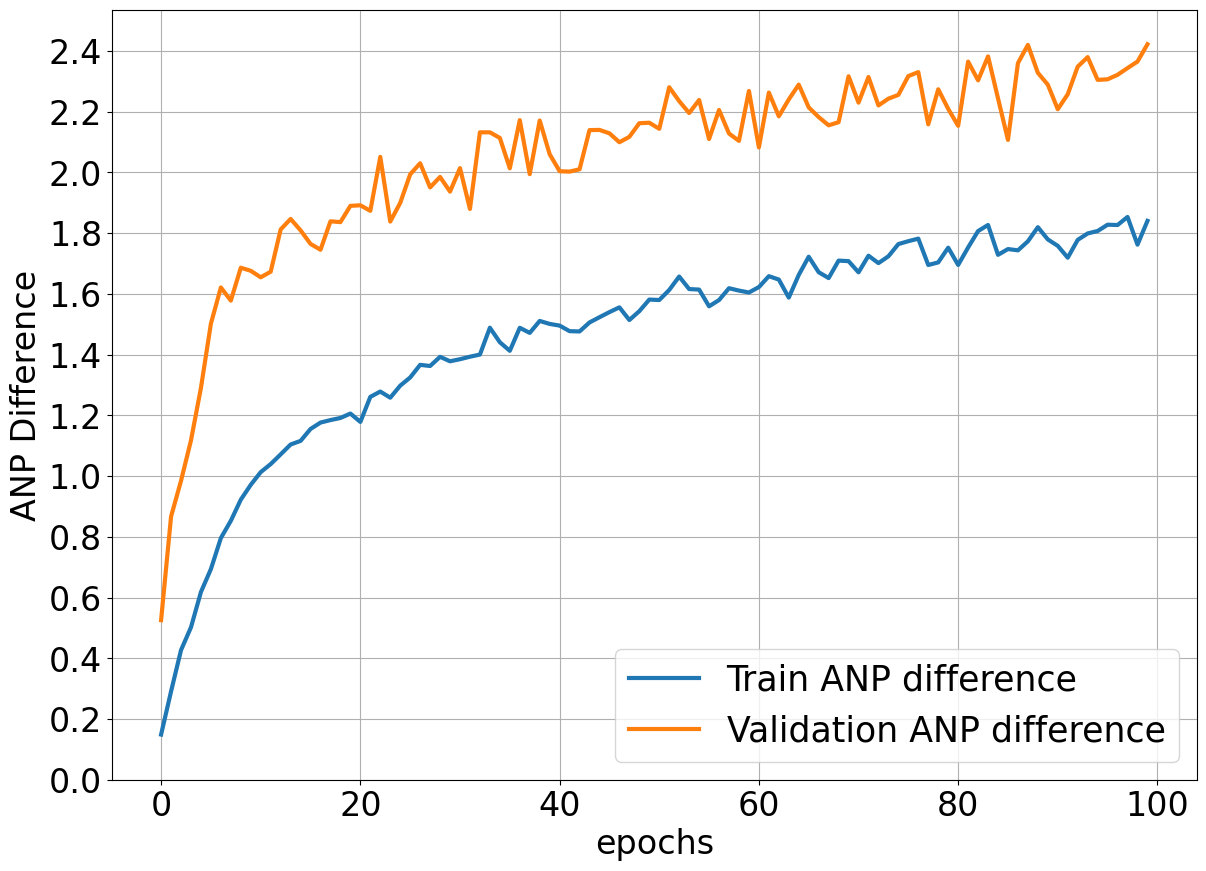

In [6]:
plt.figure(figsize=(14, 10))
plt.plot(train_an_ap_diff_list, label="Train ANP difference", linewidth=3)
plt.plot(val_an_ap_diff_list, label="Validation ANP difference", linewidth=3)

plt.yticks(ticks=np.arange(0, 2.5, 0.2), fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel("ANP Difference", fontsize=24)
plt.xlabel("epochs", fontsize=24)

plt.grid()
plt.legend(prop={'size': 25});